In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.6232 - acc: 0.3611
Epoch 00001: val_loss improved from inf to 4.35084, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_3_conv_checkpoint/001-4.3508.hdf5
36805/36805 [==============================] - 177s 5ms/sample - loss: 4.6227 - acc: 0.3611 - val_loss: 4.3508 - val_acc: 0.3909
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.9939 - acc: 0.5027
Epoch 00002: val_loss did not improve from 4.35084
36805/36805 [==============================] - 174s 5ms/sample - loss: 3.9939 - acc: 0.5028 - val_loss: 4.5791 - val_acc: 0.3979
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6962 - acc: 0.5819
Epoch 00003: val_loss improved from 4.35084 to 4.12953, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_3_conv_checkpoint/003-4.1295.h

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.2727 - acc: 0.7256
Epoch 00029: val_loss did not improve from 4.12953
36805/36805 [==============================] - 174s 5ms/sample - loss: 4.2730 - acc: 0.7256 - val_loss: 6.0568 - val_acc: 0.4976
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.2738 - acc: 0.7246
Epoch 00030: val_loss did not improve from 4.12953
36805/36805 [==============================] - 174s 5ms/sample - loss: 4.2741 - acc: 0.7245 - val_loss: 5.8020 - val_acc: 0.5262
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.2951 - acc: 0.7193
Epoch 00031: val_loss did not improve from 4.12953
36805/36805 [==============================] - 174s 5ms/sample - loss: 4.2945 - acc: 0.7193 - val_loss: 6.3867 - val_acc: 0.4766
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.2672 - acc: 0.7270
Epoch 00032: val_loss did not improve from 4.12953
36805/36805 [========

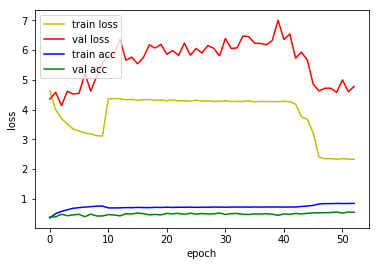

4815/4815 [==============================] - 8s 2ms/sample - loss: 4.1991 - acc: 0.4696
Loss: 4.199091407294586 Accuracy: 0.46957424

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8331 - acc: 0.4470
Epoch 00001: val_loss improved from inf to 1.60420, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_4_conv_checkpoint/001-1.6042.hdf5
36805/36805 [==============================] - 186s 5ms/sample - loss: 1.8329 - acc: 0.4470 - val_loss: 1.6042 - val_acc: 0.5041
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2090 - acc: 0.6295
Epoch 00002: val_loss improved from 1.60420 to 1.22562, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_4_conv_checkpoint/002-1.2256.hdf5
36805/36805 [==============================] - 183s 5ms/sample - loss: 1.2092 - acc: 0.6295 - val_loss: 1.2256 - val_acc: 0.6245
Epoch 3/500
36800/36805 [============================>.] 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0730 - acc: 0.9786
Epoch 00028: val_loss did not improve from 1.06396
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0730 - acc: 0.9786 - val_loss: 1.7047 - val_acc: 0.6969
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9821
Epoch 00029: val_loss did not improve from 1.06396
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0644 - acc: 0.9821 - val_loss: 1.4504 - val_acc: 0.7331
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0622 - acc: 0.9826
Epoch 00030: val_loss did not improve from 1.06396
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0622 - acc: 0.9826 - val_loss: 1.4589 - val_acc: 0.7275
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9830
Epoch 00031: val_loss did not improve from 1.06396
36805/36805 [=====================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9913
Epoch 00058: val_loss did not improve from 1.06396
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0338 - acc: 0.9913 - val_loss: 1.8412 - val_acc: 0.7254

1D_CNN_custom_ch_128_DO_025_DO_BN_4_conv Model


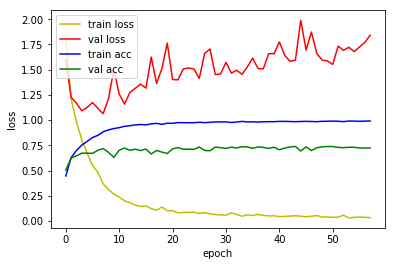

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.1581 - acc: 0.6816
Loss: 1.158068077239911 Accuracy: 0.68161994

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7217 - acc: 0.4803
Epoch 00001: val_loss improved from inf to 1.29551, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_5_conv_checkpoint/001-1.2955.hdf5
36805/36805 [==============================] - 194s 5ms/sample - loss: 1.7216 - acc: 0.4803 - val_loss: 1.2955 - val_acc: 0.5793
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0780 - acc: 0.6672
Epoch 00002: val_loss improved from 1.29551 to 1.03579, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_5_conv_checkpoint/002-1.0358.hdf5
36805/36805 [==============================] - 190s 5ms/sample - loss: 1.0779 - acc: 0.6672 - val_loss: 1.0358 - val_acc: 0.6879
Epoch 3/500
36800/36805 [============================>.] 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0699 - acc: 0.9804
Epoch 00029: val_loss did not improve from 0.78180
36805/36805 [==============================] - 189s 5ms/sample - loss: 0.0699 - acc: 0.9803 - val_loss: 1.2046 - val_acc: 0.7480
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9712
Epoch 00030: val_loss did not improve from 0.78180
36805/36805 [==============================] - 189s 5ms/sample - loss: 0.0991 - acc: 0.9713 - val_loss: 0.9482 - val_acc: 0.8027
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0688 - acc: 0.9815
Epoch 00031: val_loss did not improve from 0.78180
36805/36805 [==============================] - 189s 5ms/sample - loss: 0.0688 - acc: 0.9815 - val_loss: 0.8759 - val_acc: 0.8178
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0587 - acc: 0.9848
Epoch 00032: val_loss did not improve from 0.78180
36805/36805 [========

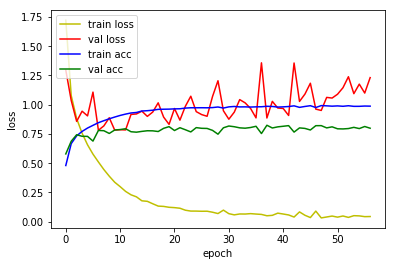

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.8222 - acc: 0.7713
Loss: 0.8222332463705156 Accuracy: 0.77133954

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6026 - acc: 0.4996
Epoch 00001: val_loss improved from inf to 1.35593, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_6_conv_checkpoint/001-1.3559.hdf5
36805/36805 [==============================] - 201s 5ms/sample - loss: 1.6025 - acc: 0.4996 - val_loss: 1.3559 - val_acc: 0.5707
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9593 - acc: 0.7030
Epoch 00002: val_loss improved from 1.35593 to 0.94519, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_6_conv_checkpoint/002-0.9452.hdf5
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.9593 - acc: 0.7030 - val_loss: 0.9452 - val_acc: 0.7079
Epoch 3/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 0.0759 - acc: 0.9782
Epoch 00026: val_loss did not improve from 0.43049
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0760 - acc: 0.9782 - val_loss: 0.7341 - val_acc: 0.8339
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0994 - acc: 0.9685
Epoch 00027: val_loss did not improve from 0.43049
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0995 - acc: 0.9685 - val_loss: 0.4891 - val_acc: 0.8847
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9781
Epoch 00028: val_loss did not improve from 0.43049
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0757 - acc: 0.9781 - val_loss: 0.8291 - val_acc: 0.8209
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0584 - acc: 0.9841
Epoch 00029: val_loss did not improve from 0.43049
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9913
Epoch 00056: val_loss did not improve from 0.43049
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0311 - acc: 0.9912 - val_loss: 0.5878 - val_acc: 0.8880
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.9849
Epoch 00057: val_loss did not improve from 0.43049
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0555 - acc: 0.9848 - val_loss: 0.5641 - val_acc: 0.8880
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9913
Epoch 00058: val_loss did not improve from 0.43049
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0326 - acc: 0.9913 - val_loss: 0.4819 - val_acc: 0.9043
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9962
Epoch 00059: val_loss did not improve from 0.43049
36805/36805 [========

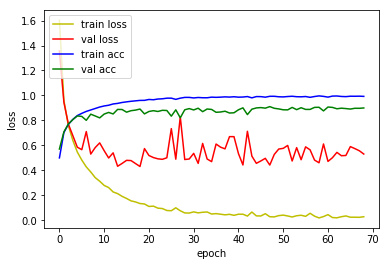

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.5021 - acc: 0.8615
Loss: 0.5021360106804909 Accuracy: 0.8614746

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5243 - acc: 0.5246
Epoch 00001: val_loss improved from inf to 1.25092, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_7_conv_checkpoint/001-1.2509.hdf5
36805/36805 [==============================] - 204s 6ms/sample - loss: 1.5242 - acc: 0.5246 - val_loss: 1.2509 - val_acc: 0.6382
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8114 - acc: 0.7536
Epoch 00002: val_loss improved from 1.25092 to 0.75560, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_7_conv_checkpoint/002-0.7556.hdf5
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.8114 - acc: 0.7536 - val_loss: 0.7556 - val_acc: 0.7773
Epoch 3/500
36800/36805 [============================>.] 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9872
Epoch 00026: val_loss did not improve from 0.21953
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0455 - acc: 0.9872 - val_loss: 0.2927 - val_acc: 0.9311
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9858
Epoch 00027: val_loss did not improve from 0.21953
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0477 - acc: 0.9858 - val_loss: 0.3621 - val_acc: 0.9012
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9856
Epoch 00028: val_loss did not improve from 0.21953
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0507 - acc: 0.9856 - val_loss: 0.2979 - val_acc: 0.9266
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9867
Epoch 00029: val_loss did not improve from 0.21953
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9930
Epoch 00055: val_loss did not improve from 0.21119
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0230 - acc: 0.9930 - val_loss: 0.2137 - val_acc: 0.9539
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9961
Epoch 00056: val_loss did not improve from 0.21119
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0147 - acc: 0.9961 - val_loss: 0.2720 - val_acc: 0.9462
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9972
Epoch 00057: val_loss did not improve from 0.21119
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0113 - acc: 0.9972 - val_loss: 0.3755 - val_acc: 0.9276
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9893
Epoch 00058: val_loss did not improve from 0.21119
36805/36805 [=====================

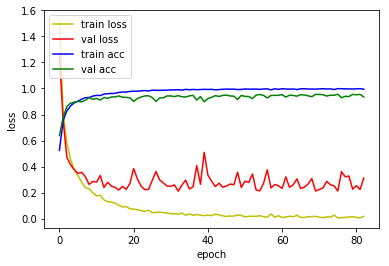

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2766 - acc: 0.9300
Loss: 0.27657951956473653 Accuracy: 0.9300104

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3808 - acc: 0.5734
Epoch 00001: val_loss improved from inf to 1.02336, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_8_conv_checkpoint/001-1.0234.hdf5
36805/36805 [==============================] - 209s 6ms/sample - loss: 1.3807 - acc: 0.5733 - val_loss: 1.0234 - val_acc: 0.6723
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5870 - acc: 0.8255
Epoch 00002: val_loss improved from 1.02336 to 0.41072, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_8_conv_checkpoint/002-0.4107.hdf5
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.5869 - acc: 0.8256 - val_loss: 0.4107 - val_acc: 0.8789
Epoch 3/500
36800/36805 [============================>.]

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9927
Epoch 00027: val_loss did not improve from 0.13785
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0269 - acc: 0.9927 - val_loss: 0.2282 - val_acc: 0.9362
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9939
Epoch 00028: val_loss did not improve from 0.13785
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0219 - acc: 0.9939 - val_loss: 0.1606 - val_acc: 0.9599
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9926
Epoch 00029: val_loss did not improve from 0.13785
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0268 - acc: 0.9926 - val_loss: 0.2384 - val_acc: 0.9383
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9928
Epoch 00030: val_loss did not improve from 0.13785
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9982
Epoch 00055: val_loss did not improve from 0.11901
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0074 - acc: 0.9982 - val_loss: 0.1664 - val_acc: 0.9613
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9977
Epoch 00056: val_loss did not improve from 0.11901
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0089 - acc: 0.9977 - val_loss: 0.1642 - val_acc: 0.9602
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9929
Epoch 00057: val_loss did not improve from 0.11901
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0242 - acc: 0.9929 - val_loss: 0.1259 - val_acc: 0.9700
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9975
Epoch 00058: val_loss did not improve from 0.11901
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9990
Epoch 00085: val_loss did not improve from 0.11901
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0036 - acc: 0.9990 - val_loss: 0.1648 - val_acc: 0.9686
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9974
Epoch 00086: val_loss did not improve from 0.11901
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0082 - acc: 0.9974 - val_loss: 0.2290 - val_acc: 0.9548
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9958
Epoch 00087: val_loss did not improve from 0.11901
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0143 - acc: 0.9958 - val_loss: 0.1561 - val_acc: 0.9653
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9990
Epoch 00088: val_loss did not improve from 0.11901
36805/36805 [========

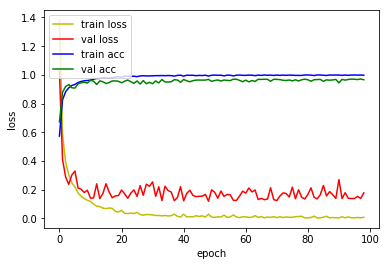

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1698 - acc: 0.9558
Loss: 0.16982969287144617 Accuracy: 0.9557632

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9833 - acc: 0.6957
Epoch 00001: val_loss improved from inf to 0.71304, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_9_conv_checkpoint/001-0.7130.hdf5
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.9831 - acc: 0.6957 - val_loss: 0.7130 - val_acc: 0.7815
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3607 - acc: 0.8864
Epoch 00002: val_loss improved from 0.71304 to 0.28746, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_9_conv_checkpoint/002-0.2875.hdf5
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.3608 - acc: 0.8863 - val_loss: 0.2875 - val_acc: 0.9131
Epoch 3/500
36800/36805 [============================>.]

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9960
Epoch 00026: val_loss did not improve from 0.12343
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0152 - acc: 0.9960 - val_loss: 0.3406 - val_acc: 0.9299
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0204 - acc: 0.9940
Epoch 00027: val_loss did not improve from 0.12343
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0204 - acc: 0.9940 - val_loss: 0.1526 - val_acc: 0.9616
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9964
Epoch 00028: val_loss did not improve from 0.12343
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0137 - acc: 0.9964 - val_loss: 0.1551 - val_acc: 0.9637
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9945
Epoch 00029: val_loss did not improve from 0.12343
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9986
Epoch 00055: val_loss did not improve from 0.11408
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0064 - acc: 0.9986 - val_loss: 0.1156 - val_acc: 0.9725
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9996
Epoch 00056: val_loss did not improve from 0.11408
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0020 - acc: 0.9996 - val_loss: 0.1410 - val_acc: 0.9662
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9970
Epoch 00057: val_loss did not improve from 0.11408
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0107 - acc: 0.9970 - val_loss: 0.1518 - val_acc: 0.9646
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9982
Epoch 00058: val_loss did not improve from 0.11408
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9967
Epoch 00084: val_loss did not improve from 0.11396
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0102 - acc: 0.9967 - val_loss: 0.1549 - val_acc: 0.9637
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9989
Epoch 00085: val_loss did not improve from 0.11396
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0039 - acc: 0.9989 - val_loss: 0.1232 - val_acc: 0.9734
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9988
Epoch 00086: val_loss did not improve from 0.11396
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0043 - acc: 0.9988 - val_loss: 0.2148 - val_acc: 0.9571
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9985
Epoch 00087: val_loss did not improve from 0.11396
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.9983
Epoch 00113: val_loss did not improve from 0.11377
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0051 - acc: 0.9983 - val_loss: 0.1478 - val_acc: 0.9702
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9991
Epoch 00114: val_loss did not improve from 0.11377
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0033 - acc: 0.9991 - val_loss: 0.1644 - val_acc: 0.9672
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9985
Epoch 00115: val_loss did not improve from 0.11377
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0050 - acc: 0.9985 - val_loss: 0.1403 - val_acc: 0.9718
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9994
Epoch 00116: val_loss did not improve from 0.11377
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9983
Epoch 00142: val_loss did not improve from 0.10924
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0062 - acc: 0.9983 - val_loss: 0.1634 - val_acc: 0.9702
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9986
Epoch 00143: val_loss did not improve from 0.10924
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0045 - acc: 0.9986 - val_loss: 0.1192 - val_acc: 0.9758
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 9.7493e-04 - acc: 0.9997
Epoch 00144: val_loss did not improve from 0.10924
36805/36805 [==============================] - 195s 5ms/sample - loss: 9.7480e-04 - acc: 0.9997 - val_loss: 0.1283 - val_acc: 0.9734
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.9997
Epoch 00145: val_loss did not improve from 0.10924
36805/36805 [==========

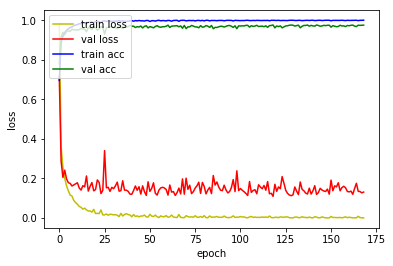

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1470 - acc: 0.9678
Loss: 0.1470132469479998 Accuracy: 0.9678089



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_DO_025_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)

#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO_025_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_025_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.8222 - acc: 0.7713
Loss: 0.8222332463705156 Accuracy: 0.77133954

1D_CNN_custom_ch_128_DO_025_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_55 (Activation)

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2766 - acc: 0.9300
Loss: 0.27657951956473653 Accuracy: 0.9300104

1D_CNN_custom_ch_128_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_68 (Activation)

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.1470 - acc: 0.9678
Loss: 0.1470132469479998 Accuracy: 0.9678089


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_025_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.5641 - acc: 0.7445
Loss: 1.5640950009582695 Accuracy: 0.74454826

1D_CNN_custom_ch_128_DO_025_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_55 (Activation

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.3652 - acc: 0.9171
Loss: 0.36520254226364696 Accuracy: 0.9171339

1D_CNN_custom_ch_128_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_68 (Activation

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.1511 - acc: 0.9701
Loss: 0.15111258443498643 Accuracy: 0.9700934
